# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 設定超參數
LEARNING_RATE = 0.001 # 0.01
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
DECAY = 1e-8

In [7]:
results = {}
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

sgd = keras.optimizers.SGD(lr=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
rms = keras.optimizers.RMSprop(lr=LEARNING_RATE, epsilon=None, decay=DECAY)
adam = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=DECAY)
adaGrad =  keras.optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=DECAY)

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=sgd)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.0

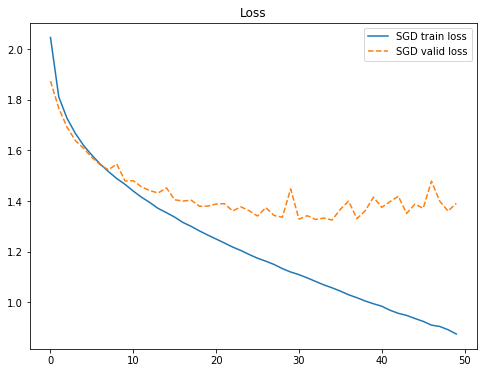

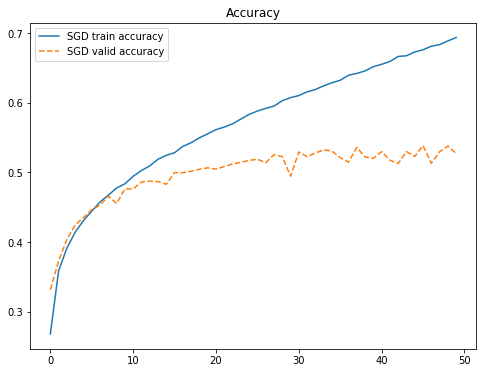

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss)),train_loss, '-', label="SGD train loss")
plt.plot(range(len(valid_loss)),valid_loss, '--', label="SGD valid loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)),train_acc, '-', label="SGD train accuracy")
plt.plot(range(len(valid_acc)),valid_acc, '--', label="SGD valid accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()